# Projet 3 - OpenFoodFacts
 Concevez une application au service de la service de la santé publique - Partie 1


## Sommaire
* La mission
* Traitement et import des données
    * Chargement du dataset
* Tri de données
* Traitement des données
    * Traitement des Nan restants
    * Traitement du timestamp
    * Traitement des doublons
    * Préparation des variables pour l'étude statistique
* Traitement des outliers
    * Traitement de la variable fat_100g
    * Traitement de la variable saturated_fat_100g
    * Traitement de la variable carbohydrates_100g
    * Traitement de la variable fiber_100g
    * Traitement de la variable salt_100g
    * Traitement de la variable sugars_100g
* Feature Engineering
    * Tri du nutrition grade
    * Traitement de la variable energy_100g
    * Traitement de la variable pnns_group_2 et main_category_fr
    * Traitement de la variable product name
* Sauvegarde du dataset nettoyé

## La mission

Après avoir lu l’appel à projets, voici les différentes étapes que vous avez identifiées :

1- Traiter le jeu de données, en :

* Réfléchissant à une idée d’application.
* Repérant des variables pertinentes pour les traitements à venir, et nécessaires pour votre idée d’application.
* Nettoyant les données en :
    * mettant en évidence les éventuelles valeurs manquantes, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
    * identifiant et en quantifiant les éventuelles valeurs aberrantes de chaque variable.
* Automatisant ces traitements pour éviter de répéter ces opérations

2- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.

3- Confirmer ou infirmer les hypothèses à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.

4- Justifier votre idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

5- Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.


## Traitement et import des données

In [21]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt



print('Verification de la mise à jour des librairies utilisées :')
print('Python: {}'.format(sys.version))
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)
print('sklearn       : ' + sklearn.__version__)

Verification de la mise à jour des librairies utilisées :
Python: 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
NumPy         : 1.21.5
Pandas        : 1.4.4
Matplotlib    : 3.5.2
Seaborn       : 0.11.2
sklearn       : 1.0.2


In [22]:
#reglage de l'affichage de données
pd.set_option('display.max_row',250)
pd.set_option('display.max_column',300)
pd.set_option('display.precision', 5)

### Chargement du dataset et des fonctions

In [23]:
#Importation du jeu de données
data = pd.read_csv('fr.openfoodfacts.org.products.csv', decimal=".", index_col=0, sep='\t', low_memory=False)

In [24]:
#Format de pourcentage avec 2 virgule en décimale
def format_percentage(value):
    return "{0:.2f}%".format(value * 100)

In [25]:
#Fonction de comptage de lignes et de colonne du dataset, affichage d'une representation graphique des sonnées manquantes
def valeurs(dataset):

#Affichage du nombre de lignes et de colonnes
    lignes = len(dataset.index)
    colonnes = len(dataset.columns)
    print('Le nombre de lignes du fichier est de ', lignes, 'et de son nombre de colonnes est de', colonnes)

#Representation graphique des données manquantes
    sns.set(rc = {'figure.figsize':(20,10)})
    sns.heatmap(dataset.isnull(), cbar=False)
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()
    plt.title('Representation graphique des valeurs manquantes', size=15)
    plt.plot()

def manquant (data):
#Affichage des colonnes pour lesquelles il manque des données en pourcentage
    nb_na_sum = data.isnull().sum()
    round(nb_na_sum[nb_na_sum>0]*100,2).sort_values(ascending = True)
    print(nb_na_sum)
#Affichage des colonnes pour lesquelles il manque des données en pourcentage
    nb_na = data.isnull().mean()
    round(nb_na[nb_na>0]*100,2).sort_values(ascending = True)
    print(nb_na)

#Taux de remplissage moyen
def donnees_manquantes(data):
    vnulles = data.isnull().sum().sum()
    nb_donnees_tot = np.product(data.shape)
    pourcentage_valeurs = round(data.isna().sum().sum()/(data.size)*100,2)
    print('Le jeu de données contient', vnulles, 'valeurs manquantes pour ',nb_donnees_tot, 'valeurs, soit', pourcentage_valeurs,'%')

#Format des données
def format_data(data):
#On affiche le format des données
    print(data.shape[0],"produits")
    print(data.shape[1],"variables")
    print("\nType des variables:\n", data.dtypes.value_counts())
#On affiche un graphique
    data.dtypes.value_counts().plot.pie()
    plt.title('Répartition du type de variable', size=15);

#Affichage de la proportion de nan dans un graphique

def proportion_nan(data):
    prop_nan = data.isna().sum().divide(data.shape[0]/100).sort_values(ascending=False)
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 30))
    ax = sns.barplot(y = prop_nan.index, x=prop_nan.values)
    ax.xaxis.set_ticks_position('top')
    plt.title('Quantité de données manquantes par colonne dans le jeu de données (en %)', size=15)
    plt.show()

    # On en profite pour regarder la distribution des Nan
    sns.set(style="whitegrid")
    ax = sns.distplot(prop_nan.values)
    ax.xaxis.set_ticks_position('top')
    plt.title('Répartition de la quantité de NaN', size=15)
    plt.show()

def doublons(data, colonne):
    # Ne pas oublier les '' dans le nom de la colonne
    data_doublons = data.loc[:,colonne:].columns
    data_doub = data.duplicated(subset=data_doublons, keep='first').value_counts()
    return data_doub

def suppr_doublons(data, colonne):
# Ne pas oublier les '' dans le nom de la colonne
    data_doublons = data.loc[:,'product_name':].columns
    data = data[~data.duplicated(subset=data_doublons, keep='first')]

#Suppression des lignes contentant des outliers
def outliers_data(data, valeur):

    outliers_data = data[data[valeur] > 100].index
    data.drop(outliers_data, inplace=True)

    return data[data[valeur] > 100]

def outliers_neg(data, valeur):

    outliers_data = data[data[valeur] < 0].index
    data.drop(outliers_data, inplace=True)

    return data[data[valeur] < 0]



## Découverte du fichier

### Découverte globale du fichier

In [26]:
data.head(5)

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [27]:
data.tail()

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9948282780603,http://world-fr.openfoodfacts.org/produit/9948...,openfoodfacts-contributors,1490631299,2017-03-27T16:14:59Z,1491244498,2017-04-03T18:34:58Z,Tomato & ricotta,NaN,1,Plastique,plastique,Panzani,panzani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:RO,en:romania,Roumanie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,NaN,Plastique,plastique,Trader Joe's,trader-joe-s,NaN,NaN,NaN,NaN,NaN

#### Contrôle des colonnes

In [28]:
data.columns

Index(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime', 'product_name', 'generic_name', 'quantity',
       'packaging',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=161)

In [29]:
data.columns.to_list()

['url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_u

In [30]:
### Données manquantes

In [31]:
donnees_manquantes(data)

Le jeu de données contient 39608566 valeurs manquantes pour  51644292 valeurs, soit 76.69 %


Le nombre de lignes du fichier est de  320772 et de son nombre de colonnes est de 161


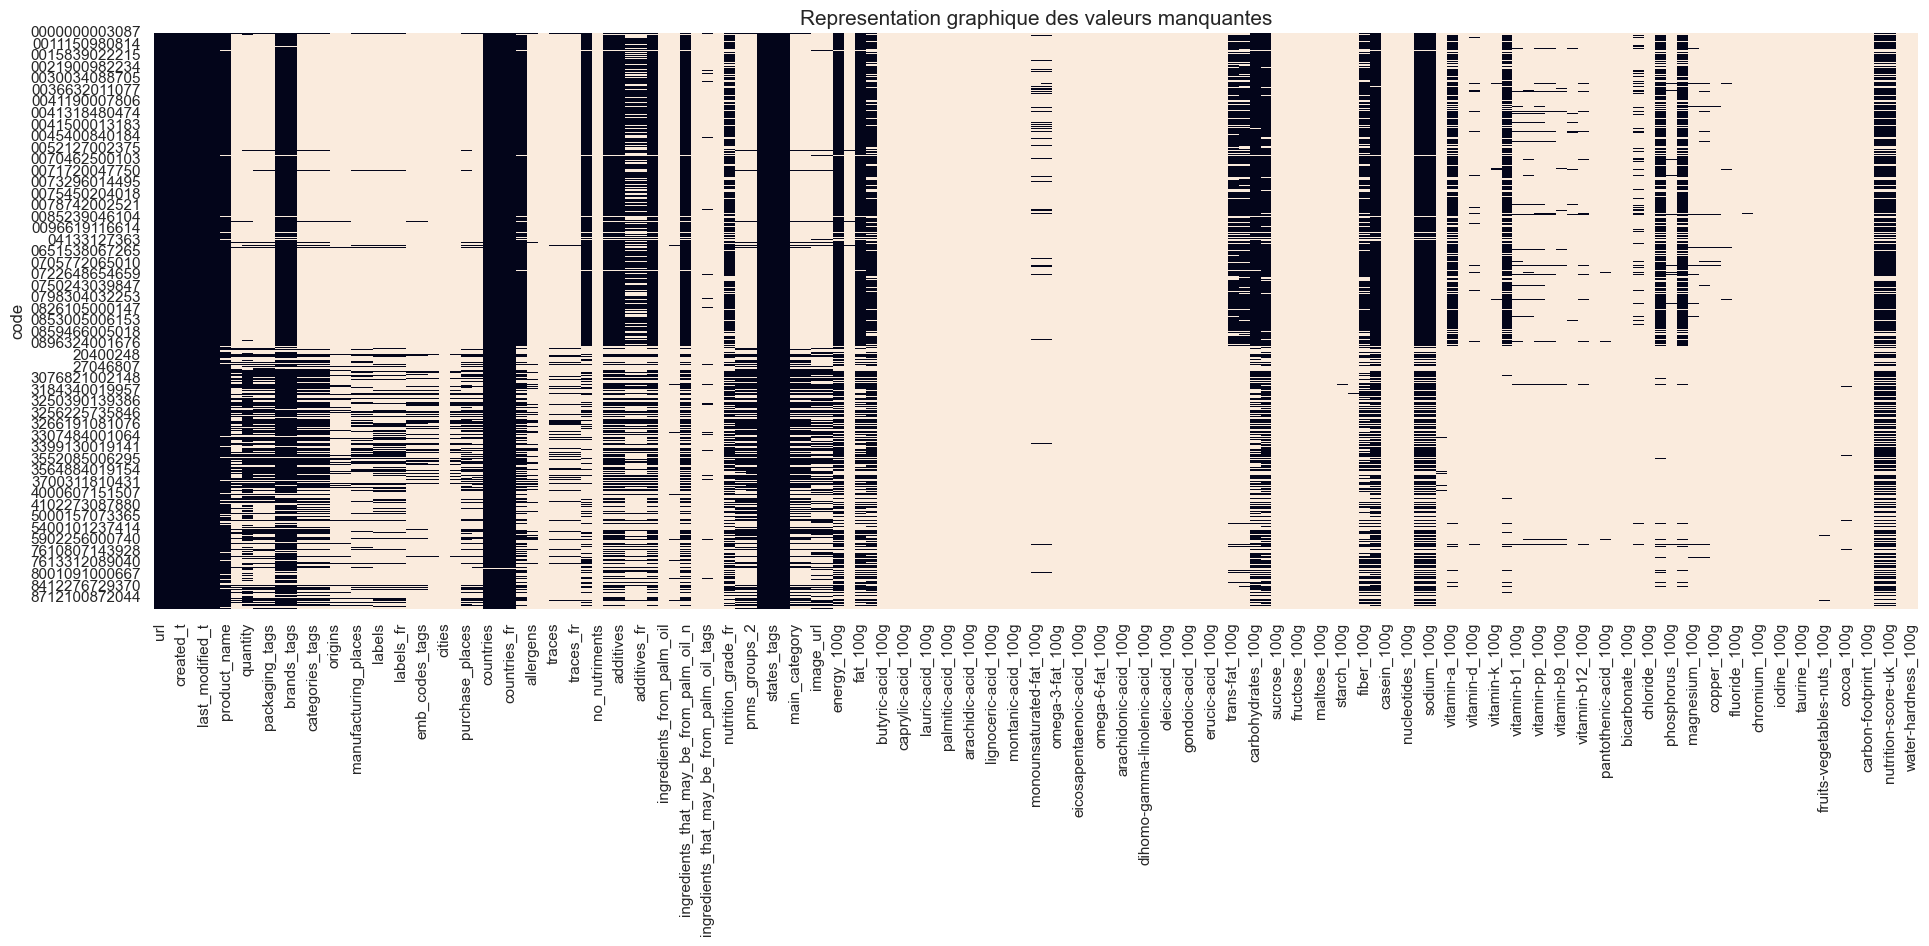

In [32]:
valeurs(data)

Le dataset est vide à 76,69%. Il présente 161 colonnes et 320772 lignes.

In [33]:
manquant(data)

url                                               23
creator                                            2
created_t                                          3
created_datetime                                   9
last_modified_t                                    0
last_modified_datetime                             0
product_name                                   17762
generic_name                                  267977
quantity                                      215953
packaging                                     241812
packaging_tags                                241811
brands                                         28412
brands_tags                                    28420
categories                                    236362
categories_tags                               236383
categories_fr                                 236361
origins                                       298582
origins_tags                                  298619
manufacturing_places                          

### Format des données

320772 produits
161 variables

Type des variables:
 float64    106
object      55
dtype: int64


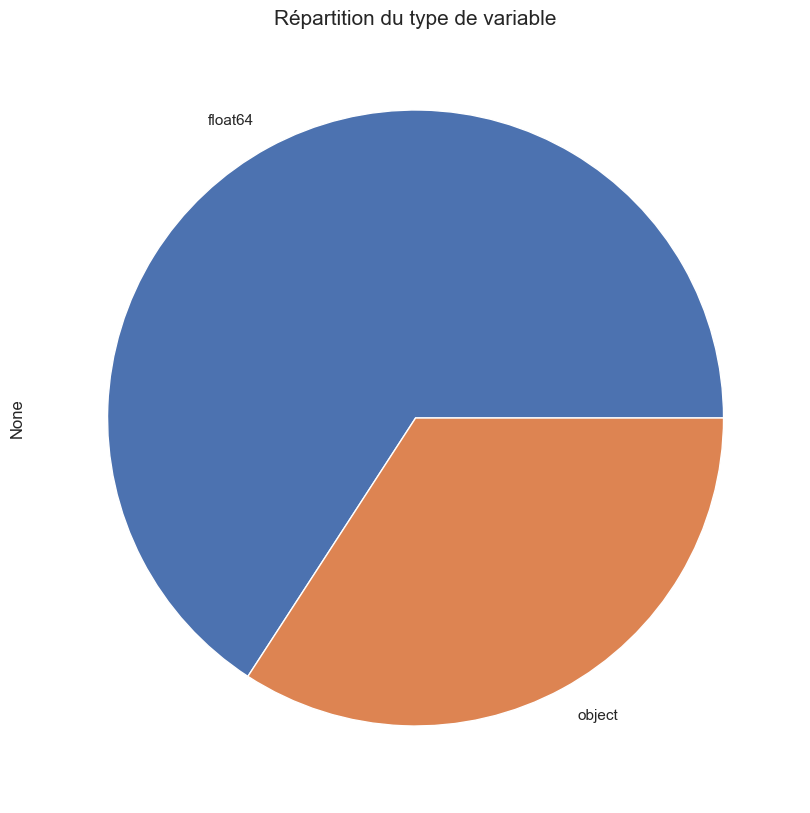

In [34]:
format_data(data)

Le jeu de données est principalement composé de valeurs numériques.

#### Affichage du contenu des variables catégorielles

In [35]:
# Signification des variables catégorielles de type Object (texte) :

for col in data.select_dtypes('object'):
    print(f'{col :-<40} {data[col].unique()}')

url------------------------------------- ['http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao'
 'http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole'
 'http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser'
 ...
 'http://world-fr.openfoodfacts.org/produit/9970229501521/%E4%B9%90%E5%90%A7%E6%B3%A1%E8%8F%9C%E5%91%B3%E8%96%AF%E7%89%87-%E4%B9%90%E5%90%A7'
 'http://world-fr.openfoodfacts.org/produit/9980282863788/tomates-aux-vermicelles-knorr'
 'http://world-fr.openfoodfacts.org/produit/999990026839/sugar-free-drink-mix-peach-tea-market-pantry']
creator--------------------------------- ['openfoodfacts-contributors' 'usda-ndb-import' 'date-limite-app' ...
 'zmorlock' 'robopetr' 'mmarquesma']
created_t------------------------------- ['1474103866' '1489069957' '1489055731' ... '1490631299' '1422099377'
 '1492340089']
created_datetime------------------------ ['2016-09-17T09:17:46Z' '2017-03-09T14:32:

Les variables catégorielles de type Object représentent les informations concernant les pays, les compositions non variables (additifs, exhausteurs...), les url avec le photos des produits ainsi que divers commentaires. La plupart ne présente pas d'interet à notre étude.

### Réduction du data set en fonction du pays

In [36]:
# On affiche les pays représentés dans le fichier afin de ne sélectionner que la france.
print('Region :\n' ,data['countries_fr'].unique())

Region :
 ['France' 'États-Unis' 'Royaume-Uni' 'France,États-Unis' 'Canada' 'Suisse'
 'Espagne' 'Allemagne' 'Slovénie' 'Italie' 'Roumanie' 'Australie'
 'Portugal' 'France,Royaume-Uni' 'Belgique,France,Pays-Bas,Royaume-Uni'
 'Guadeloupe' nan 'Royaume-Uni,États-Unis' 'Canada,États-Unis' 'Pays-Bas'
 'Australie,France' 'Canada,France,Suisse,États-Unis'
 'France,États-Unis,en:Etats-unis' 'Irlande' 'France,La Réunion' 'Taiwan'
 'Australie,Suisse' 'France,Allemagne' 'Brésil' 'Belgique,France'
 'République dominicaine' 'États-Unis,en:Australie' 'Arabie saoudite'
 'Émirats arabes unis' 'Irak' 'Koweït' 'Moldavie' 'Belgique'
 'Nouvelle-Calédonie' 'Singapour' 'Finlande' 'Australie,États-Unis'
 'France,Suisse'
 'Australie,Nouvelle-Zélande,Singapour,Thaïlande,États-Unis'
 'Polynésie française' 'Panama' 'Costa Rica' 'Mexique'
 'États-Unis,en:Pays-bas' 'Espagne,Royaume-Uni,en:Scotland'
 'Polynésie française,États-Unis' 'Thaïlande' 'Chine' 'Luxembourg' 'Liban'
 'Suisse,États-Unis' 'Allemagne,États-Unis

In [37]:
# On ne selectionne que la france, on supprime tous le reste
print("Taille food avant sélection de la France:",len(data))
data_fr = data[data.countries.str.contains(r'en:france|en:fr|en:FR|en:French|France|Frankreich|Francia|Francja|en:Frankrijk|Franciaorszag|Frankrijk', na=False)]
print("Taille food après sélection de la France:",len(data_fr))

Taille food avant sélection de la France: 320772
Taille food après sélection de la France: 98371


Notre dataset subit une réduction substantielle avec la suppression des pays autres que la france. Il ne reste que 30 % des données.

## Tri

Dictionnaire de variables non-utiles

non_utiles = ['url', 'creator', 'packaging_tags', 'Brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tag', 'origins_tags', 'origins', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tag', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'countries_tags', 'countries', 'purchase_places', 'stores', 'states', 'states_tags', 'main_category' 'allergens', 'traces', 'traces_tags', 'additives', 'additives_tags' 'nutrition_grade_uk']



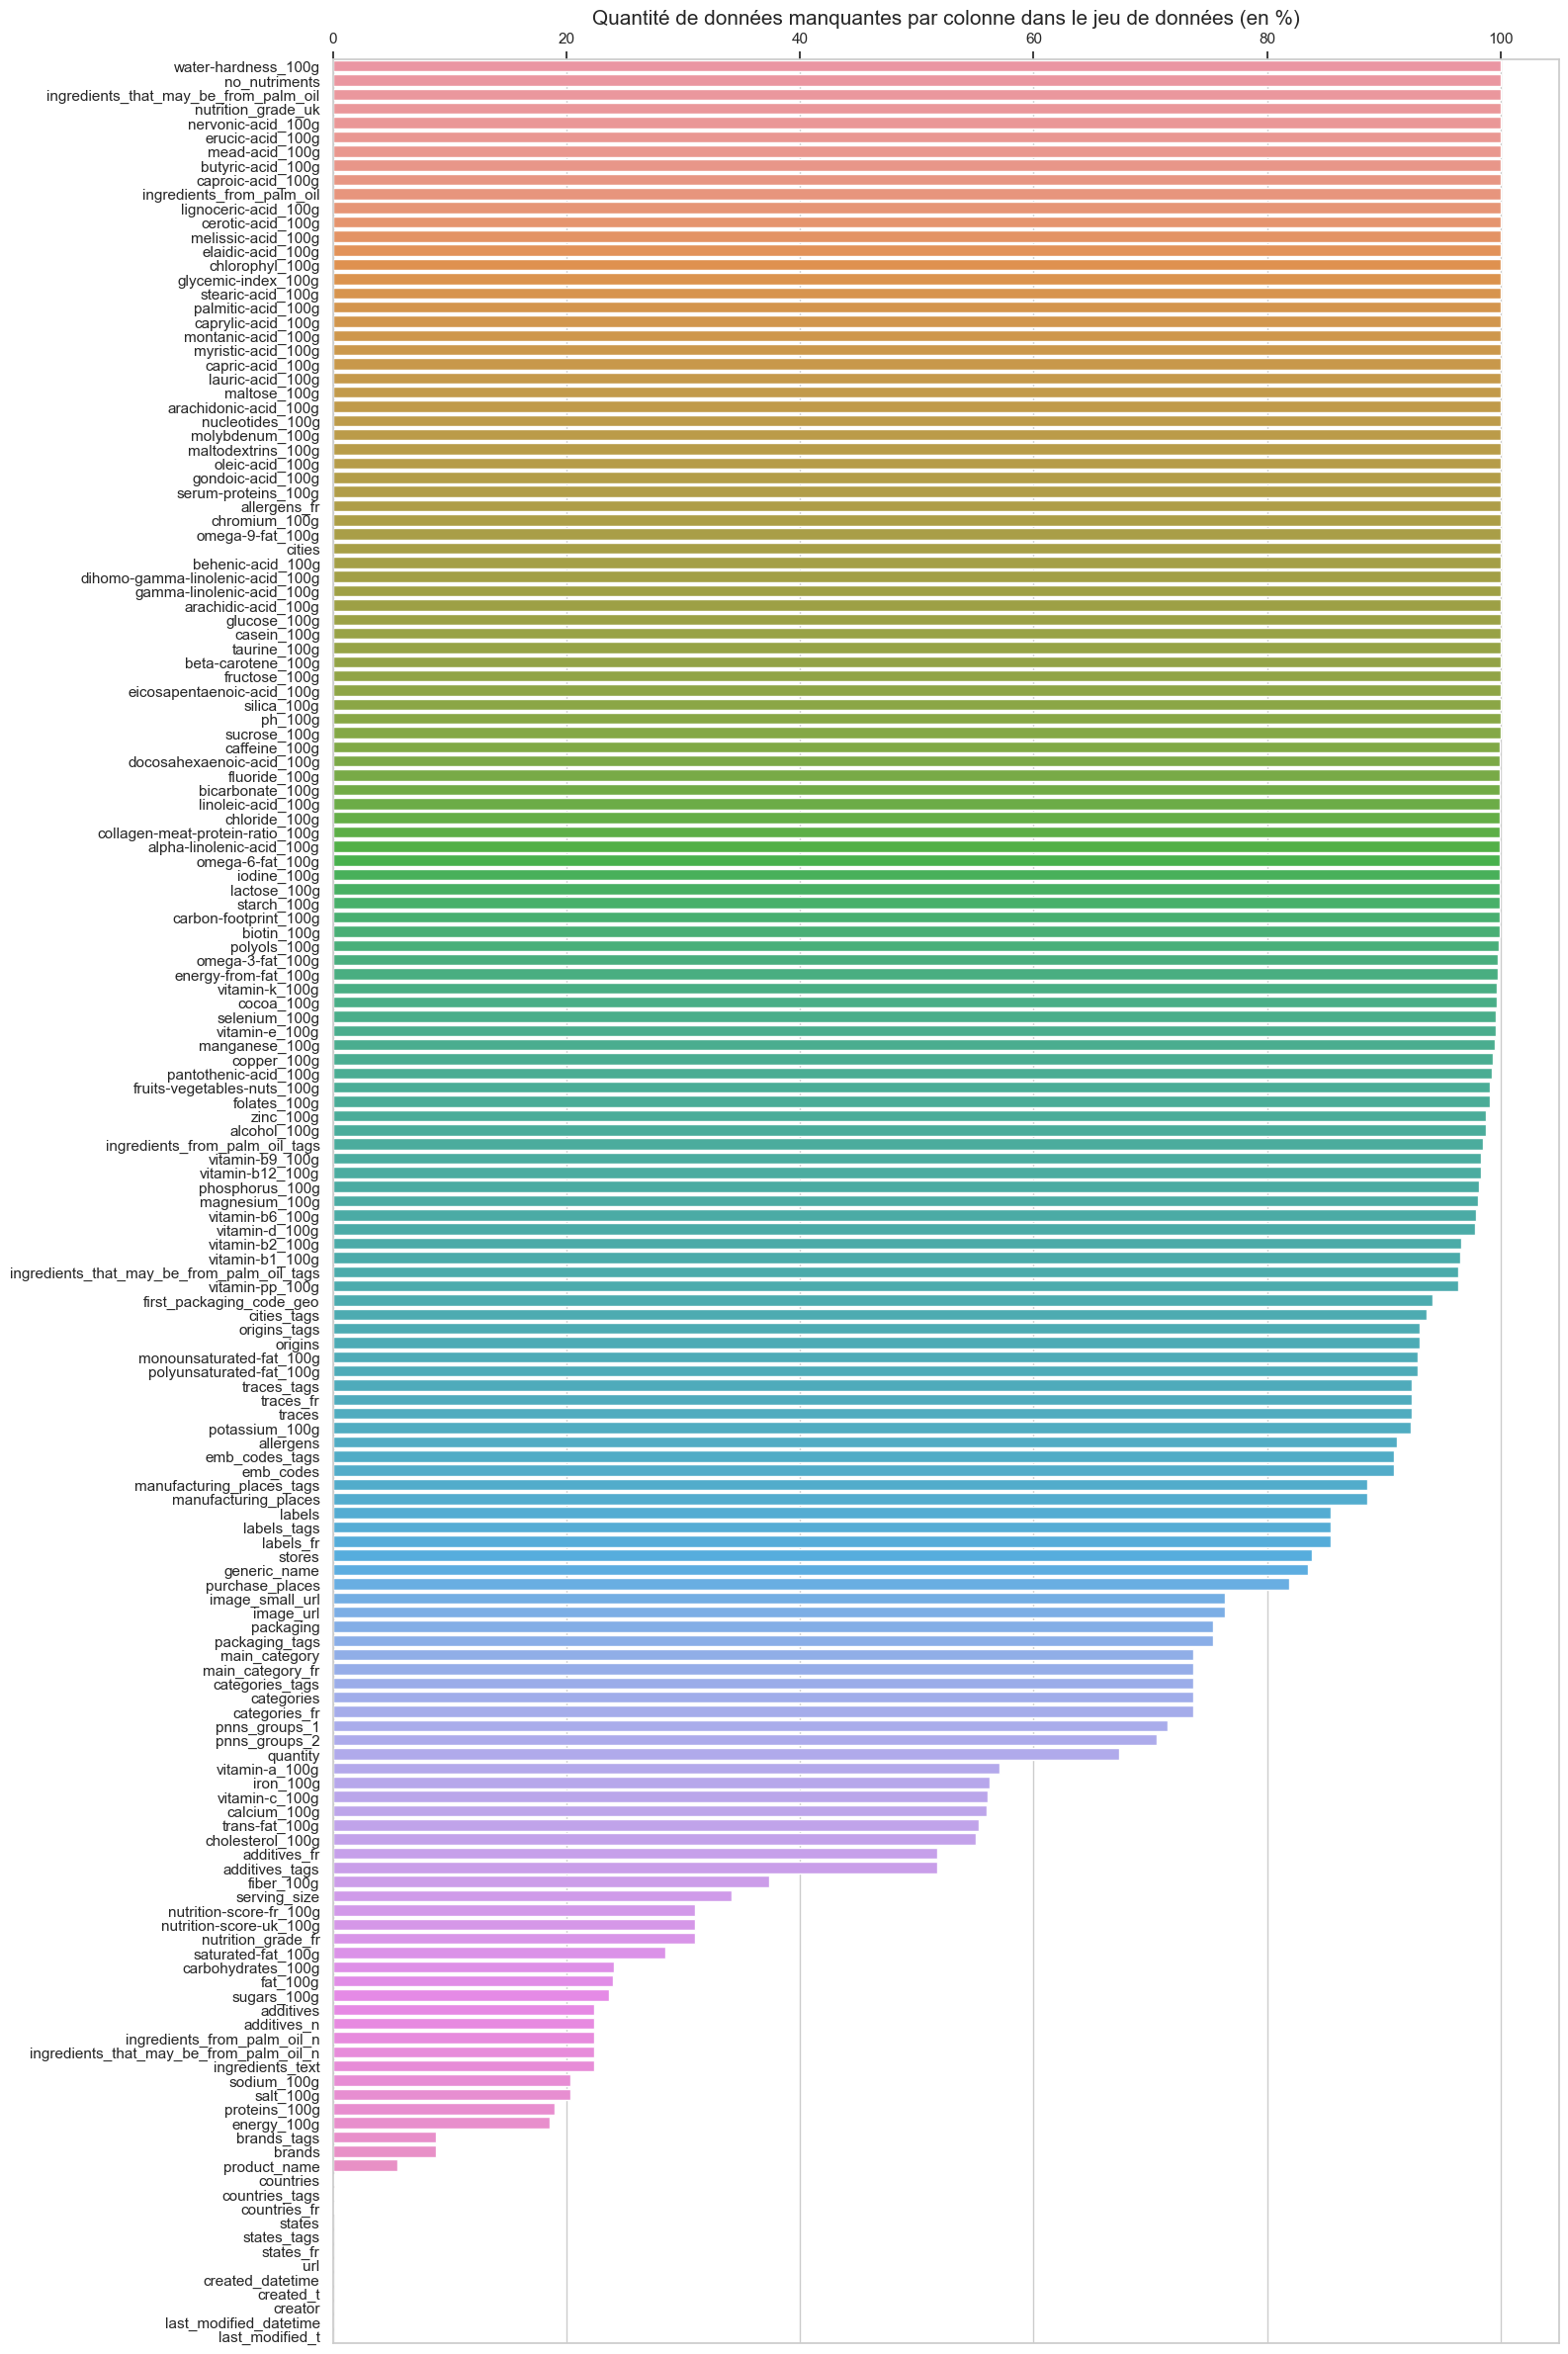

/Users/xavierparisot/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


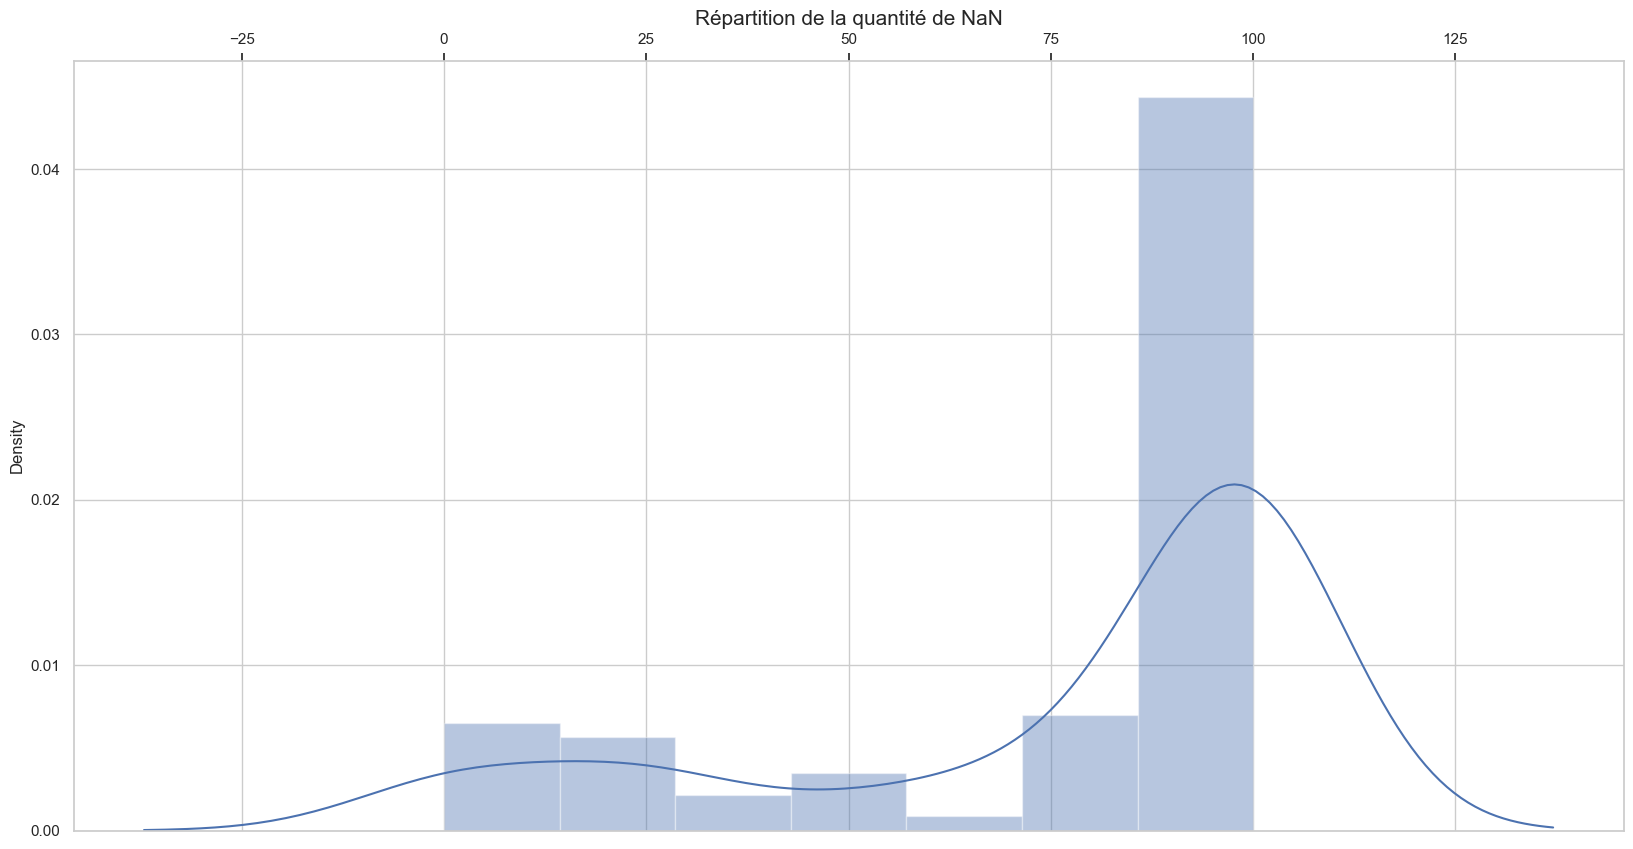

In [38]:
#On affiche la proportion de nan dans le fichier
proportion_nan(data)

Nous considérons que les variables ayant plus de 80 % de données non renseignées sont inexploitables, nous les supprimons.

#Création du dictionnaire de données vides
vides = ['water-hardness_100g', 'no_nutriments', 'mead-acid_100g', 'melissic-acid_100g', 'cerotic-acid_100g', 'lignoceric-acid_100g', 'caproic-acid_100g', 'butyric-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'nutrition_grade_uk', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil', 'elaidic-acid_100g', 'glycemic-index_100g', 'chlorophyl_100g', 'silica_100g', 'casein_100g', 'glucose_100g', 'cities', 'chromium_100g', 'beta-carotene_100g', 'taurine_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'eicosapentaenoic-acid_100g', 'gamma-linolenic-acid_100g', 'allergens_fr', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'fructose_100g', 'ph_100g' ,'caffeine_100g' ,'docosahexaenoic-acid_100g', 'fluoride_100g', 'sucrose_100g', 'bicarbonate_100g', 'linoleic-acid_100g', 'collagen-meat-protein-ratio_100g', 'chloride_100g', 'alpha-linolenic-acid_100g', 'omega-6-fat_100g', 'iodine_100g', 'carbon-footprint_100g', 'lactose_100g', 'starch_100g', 'biotin_100g', 'polyols_100g', 'omega-3-fat_100g', 'energy-from-fat_100g', 'vitamin-k_100g', 'cocoa_100g', 'selenium_100g', 'vitamin-e_100g', 'manganese_100g', 'copper_100g', 'pantothenic-acid_100g', 'folates_100g', 'fruits-vegetables-nuts_100g', 'caprylic-acid_100g', 'maltose_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'montanic-acid_100g', 'gondoic-acid_100g', 'molybdenum_100g', 'oleic-acid_100g', 'arachidonic-acid_100g', 'maltodextrins_100g', 'nucleotides_100g', 'serum-proteins_100g', 'zinc_100g', 'potassium_100g', 'trans-fat_100g', 'cholesterol_100g', 'vitamin-b12_100g', 'phosphorus_100g', 'vitamin-a_100g', 'vitamin-d_100g', 'vitamin-b2_100g', 'vitamin-b9_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'magnesium_100g', 'vitamin-b1_100g']

/var/folders/fm/4l9cd8f55vb4b4fb84ww8jx00000gn/T/ipykernel_10907/4201656704.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_fr = data_fr.drop(['url', 'creator', 'packaging_tags', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'origins_tags', 'origins', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'countries_tags', 'countries', 'purchase_places', 'stores', 'states', 'states_tags', 'main_category', 'allergens', 'traces', 'traces_tags', 'additives', 'additives_tags', 'nutrition_grade_uk','water-hardness_100g', 'no_nutriments', 'mead-acid_100g', 'melissic-acid_100g', 'cerotic-acid_100g', 'lignoceric-acid_100g', 'caproic-acid_100g', 'butyric-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'nutrition_grade_uk', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_

Le nombre de lignes du fichier est de  98371 et de son nombre de colonnes est de 34


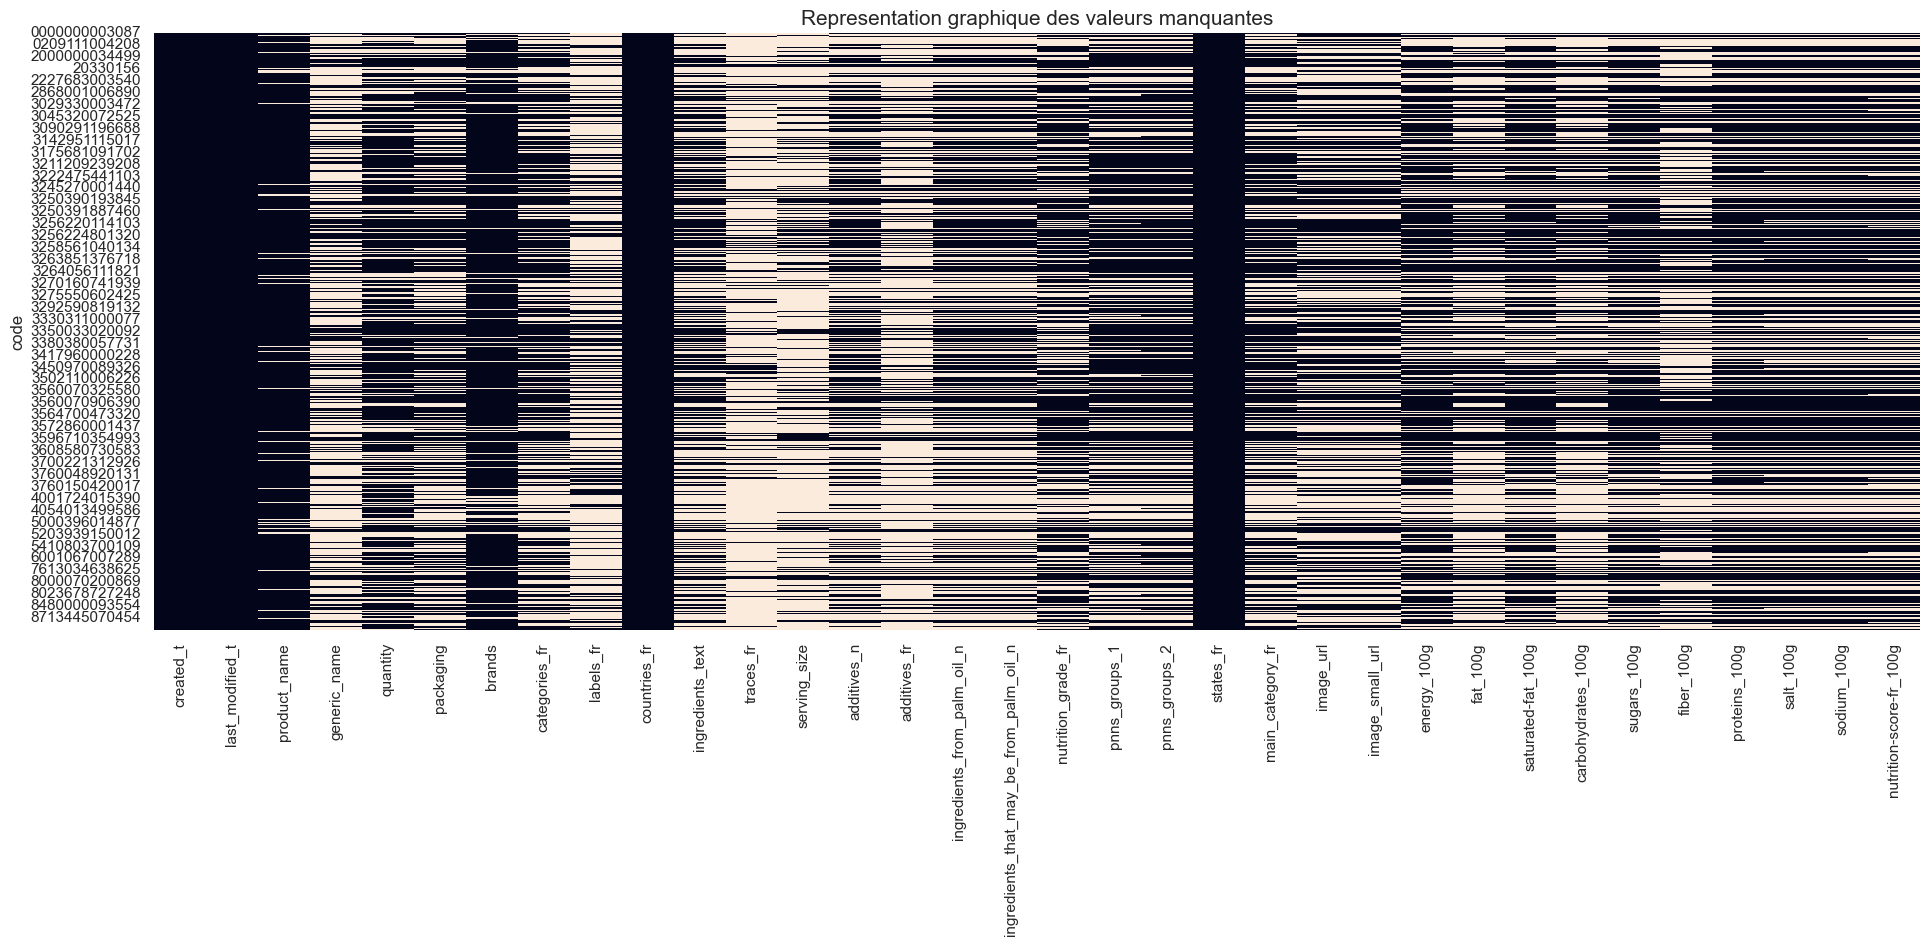

In [39]:
# On commence par supprimer les variables qui ne nous intéressent pas ou qui sont vides
data_fr = data_fr.drop(['url', 'creator', 'packaging_tags', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'origins_tags', 'origins', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'countries_tags', 'countries', 'purchase_places', 'stores', 'states', 'states_tags', 'main_category', 'allergens', 'traces', 'traces_tags', 'additives', 'additives_tags', 'nutrition_grade_uk','water-hardness_100g', 'no_nutriments', 'mead-acid_100g', 'melissic-acid_100g', 'cerotic-acid_100g', 'lignoceric-acid_100g', 'caproic-acid_100g', 'butyric-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'nutrition_grade_uk', 'ingredients_that_may_be_from_palm_oil', 'ingredients_from_palm_oil', 'elaidic-acid_100g', 'glycemic-index_100g', 'chlorophyl_100g', 'silica_100g', 'casein_100g', 'glucose_100g', 'cities', 'chromium_100g', 'beta-carotene_100g', 'taurine_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'eicosapentaenoic-acid_100g', 'gamma-linolenic-acid_100g', 'allergens_fr', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'fructose_100g', 'ph_100g' ,'caffeine_100g' ,'docosahexaenoic-acid_100g', 'fluoride_100g', 'sucrose_100g', 'bicarbonate_100g', 'linoleic-acid_100g', 'collagen-meat-protein-ratio_100g', 'chloride_100g', 'alpha-linolenic-acid_100g', 'omega-6-fat_100g', 'iodine_100g', 'carbon-footprint_100g', 'lactose_100g', 'starch_100g', 'biotin_100g', 'polyols_100g', 'omega-3-fat_100g', 'energy-from-fat_100g', 'vitamin-k_100g', 'cocoa_100g', 'selenium_100g', 'vitamin-e_100g', 'manganese_100g', 'copper_100g', 'pantothenic-acid_100g', 'folates_100g', 'fruits-vegetables-nuts_100g', 'caprylic-acid_100g', 'maltose_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'montanic-acid_100g', 'gondoic-acid_100g', 'molybdenum_100g', 'oleic-acid_100g', 'arachidonic-acid_100g', 'maltodextrins_100g', 'nucleotides_100g', 'serum-proteins_100g', 'zinc_100g', 'potassium_100g', 'trans-fat_100g', 'cholesterol_100g', 'vitamin-b12_100g', 'phosphorus_100g', 'vitamin-a_100g', 'vitamin-d_100g', 'vitamin-b2_100g', 'vitamin-b9_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'magnesium_100g', 'vitamin-b1_100g','created_datetime', 'last_modified_datetime', 'iron_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'vitamin-c_100g', 'calcium_100g', 'alcohol_100g', 'nutrition-score-uk_100g', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags' ], 1)

# On affiche le résultat
valeurs(data_fr)

## Traitement des données

### Traitement des Nan restants

Le traitement des Nan est délicat en général, mais avec ce type de données le problème est exacerbé. Un nan dans une variable de nutriment n'est pas forcément une valeur manquante, il peut être une valeur non existante : Le sucre dans 1 kilos de sel.
La décision est de ne traiter les Nan qu'au cas par cas.

In [40]:
#Pourcentage de nan restant
manquant(data_fr)

created_t                                      0
last_modified_t                                0
product_name                                7154
generic_name                               60096
quantity                                   27168
packaging                                  39420
brands                                     11986
categories_fr                              36447
labels_fr                                  63250
countries_fr                                   0
ingredients_text                           44921
traces_fr                                  79220
serving_size                               72030
additives_n                                44921
additives_fr                               67930
ingredients_from_palm_oil_n                44921
ingredients_that_may_be_from_palm_oil_n    44921
nutrition_grade_fr                         36967
pnns_groups_1                              33531
pnns_groups_2                              31375
states_fr           

### Traitement du timestamp

In [41]:
#Format timestamp des données - Nous ne conservons que les cellules _t
data_fr['created_t'] = pd.to_datetime(data_fr['created_t'], unit='s').dt.strftime("%Y%m%d")
data_fr['last_modified_t'] = pd.to_datetime(data_fr['last_modified_t'], unit='s').dt.strftime("%Y%m%d")

### Traitement des doublons

In [42]:
#Recherche des doublons sur toutes les colonnes a l'exception de la colonne product_name
doublons(data_fr, 'product_name')

False    94234
True      4137
dtype: int64

In [43]:
#suppression des doublons
suppr_doublons(data_fr, 'product_name')

In [44]:
#Recherche des doublons sur la colonne product_name
data_fr[data_fr['product_name'].notnull()].duplicated(subset=['product_name'], keep='first').value_counts()

False    74335
True     16882
dtype: int64

In [45]:
#Approfondissement de la recherche en ajoutant les colonnes de composants
data_fr.duplicated(subset=['product_name', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'], keep='first').value_counts()

False    86984
True     11387
dtype: int64

La recherche de doublons approfondie a trouvé moins de valeurs en doublon, mais ce sont de vrais doublons. Je vais les supprimer.


### Préparation des variables pour l'étude statistique

Nous créons un dataframe contenant les variables numériques sélectionnées pour notre étude

In [46]:
#préparation du Df
data_fr = data_fr[~data_fr.duplicated(subset=['product_name', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'], keep='first')]

In [47]:
# Nous considérons que les Nan sont des 0 (nutriments non présents dans les produits)
data_fr = data_fr.fillna(0)

86984 produits
34 variables

Type des variables:
 object     21
float64    13
dtype: int64


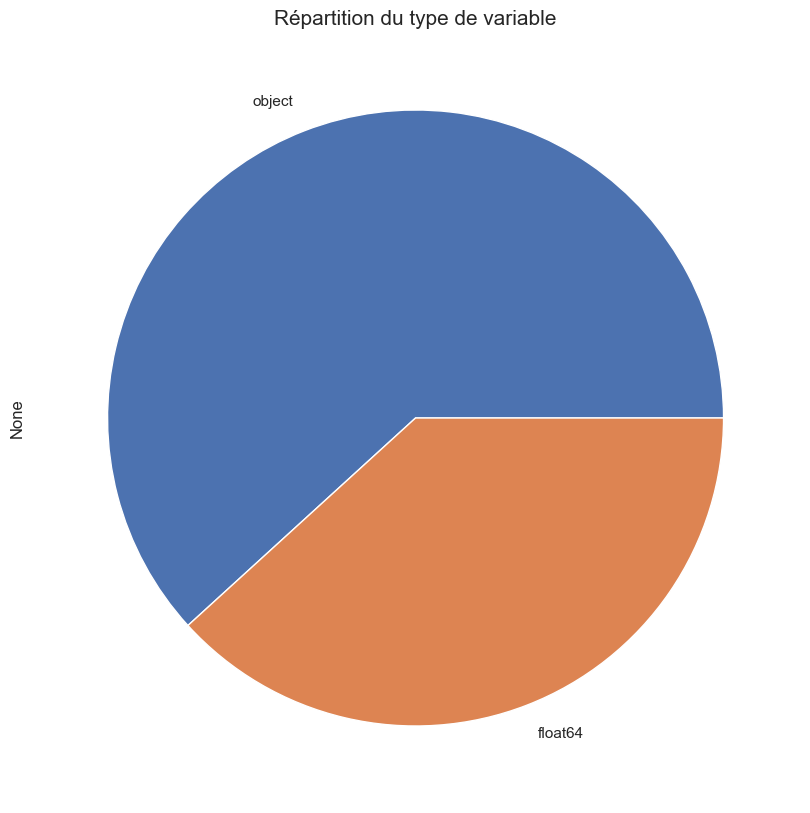

In [48]:
# Affichage des variables
format_data(data_fr)

In [49]:
# Création du Df avec les variables numériques
data_chiffres = data_fr[["energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g", "nutrition-score-fr_100g"]]

In [50]:
# On remplace les '-' par des '_'
data_fr.rename(columns={'saturated-fat_100g' : 'saturated_fat_100g'}, inplace=True)
data_chiffres.rename(columns={'saturated-fat_100g' : 'saturated_fat_100g'}, inplace=True)

/var/folders/fm/4l9cd8f55vb4b4fb84ww8jx00000gn/T/ipykernel_10907/4081264616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chiffres.rename(columns={'saturated-fat_100g' : 'saturated_fat_100g'}, inplace=True)


In [51]:
# On remplace les '-' par des '_'
data_fr.rename(columns={'nutrition-score-fr_100g' : 'nutrition_score_fr_100g'}, inplace=True)

In [52]:
data_colonnes = data_chiffres.columns.to_list()

In [53]:
#Creation d'un tableau donnant les moyennes et les médianes des indicateurs retenus pour le choix final
files_description = pd.DataFrame(columns = ["Minimum", "Maximum", "Médianes", "Moyennes", "Variance", "Ecart-Type"],
                                 index = ["energy_100g",
                                          "fat_100g",
                                          "saturated_fat_100g",
                                          "carbohydrates_100g",
                                          "sugars_100g",
                                          "fiber_100g",
                                          "proteins_100g",
                                          "salt_100g",
                                          "sodium_100g"])

#Remplissage des minimum pour chaque indicateur
files_description["Minimum"] = [
    round(data_fr['energy_100g'].min(),2),
    round(data_fr['fat_100g'].min(),2),
    round(data_fr['saturated_fat_100g'].min(),2),
    round(data_fr['carbohydrates_100g'].min(),2),
    round(data_fr['sugars_100g'].min(),2),
    round(data_fr['fiber_100g'].min(),2),
    round(data_fr['proteins_100g'].min(),2),
    round(data_fr['salt_100g'].min(),2),
    round(data_fr['sodium_100g'].min(),2)
]

#Remplissage des maximum pour chaque indicateur
files_description["Maximum"] = [
    round(data_fr['energy_100g'].max(),2),
    round(data_fr['fat_100g'].max(),2),
    round(data_fr['saturated_fat_100g'].max(),2),
    round(data_fr['carbohydrates_100g'].max(),2),
    round(data_fr['sugars_100g'].max(),2),
    round(data_fr['fiber_100g'].max(),2),
    round(data_fr['proteins_100g'].max(),2),
    round(data_fr['salt_100g'].max(),2),
    round(data_fr['sodium_100g'].max(),2)
]

#Remplissage des médianes pour chaque indicateur
files_description["Médianes"] = [
   round(data_fr['energy_100g'].median(),2),
    round(data_fr['fat_100g'].median(),2),
    round(data_fr['saturated_fat_100g'].median(),2),
    round(data_fr['carbohydrates_100g'].median(),2),
    round(data_fr['sugars_100g'].median(),2),
    round(data_fr['fiber_100g'].median(),2),
    round(data_fr['proteins_100g'].median(),2),
    round(data_fr['salt_100g'].median(),2),
    round(data_fr['sodium_100g'].median(),2)
]

#Remplissage des moyennes pour chaque fichier
files_description["Moyennes"] = [
    round(data_fr['energy_100g'].mean(),2),
    round(data_fr['fat_100g'].mean(),2),
    round(data_fr['saturated_fat_100g'].mean(),2),
    round(data_fr['carbohydrates_100g'].mean(),2),
    round(data_fr['sugars_100g'].mean(),2),
    round(data_fr['fiber_100g'].mean(),2),
    round(data_fr['proteins_100g'].mean(),2),
    round(data_fr['salt_100g'].mean(),2),
    round(data_fr['sodium_100g'].mean(),2)
]

#Remplissage de la variance pour chaque fichier
files_description["Variance"] = [
    round(data_fr['energy_100g'].var(),2),
    round(data_fr['fat_100g'].var(),2),
    round(data_fr['saturated_fat_100g'].var(),2),
    round(data_fr['carbohydrates_100g'].var(),2),
    round(data_fr['sugars_100g'].var(),2),
    round(data_fr['fiber_100g'].var(),2),
    round(data_fr['proteins_100g'].var(),2),
    round(data_fr['salt_100g'].var(),2),
    round(data_fr['sodium_100g'].var(),2)
]

#Remplissage de l'écart-type pour chaque fichier
files_description["Ecart-Type"] = [
   round(data_fr['energy_100g'].std(),2),
    round(data_fr['fat_100g'].std(),2),
    round(data_fr['saturated_fat_100g'].std(),2),
    round(data_fr['carbohydrates_100g'].std(),2),
    round(data_fr['sugars_100g'].std(),2),
    round(data_fr['fiber_100g'].std(),2),
    round(data_fr['proteins_100g'].std(),2),
    round(data_fr['salt_100g'].std(),2),
    round(data_fr['sodium_100g'].std(),2)
]

files_description

,Minimum,Maximum,Médianes,Moyennes,Variance,Ecart-Type
energy_100g,0.0,3251373.0,544.00,857.04,1.22608e+08,11072.83
fat_100g,0.0,380.0,0.00,7.13,1.94500e+02,13.95
saturated_fat_100g,0.0,210.0,0.50,3.83,5.73800e+01,7.58
carbohydrates_100g,0.0,190.0,0.50,14.82,5.92150e+02,24.33
sugars_100g,-0.1,105.0,1.50,9.50,2.93930e+02,17.14
fiber_100g,0.0,178.0,0.00,1.33,1.28600e+01,3.59
proteins_100g,0.0,100.0,3.00,5.66,5.72700e+01,7.57
salt_100g,0.0,211.0,0.10,0.82,1.35900e+01,3.69
sodium_100g,0.0,83.0,0.04,0.32,2.11000e+00,1.45


In [54]:
data_chiffres.describe()

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,8.69840e+04,86984.00000,86984.00000,86984.00000,86984.00000,86984.00000,86984.00000,86984.00000,86984.00000,86984.00000
mean,8.57044e+02,7.12927,3.83093,14.81537,9.50300,1.33129,5.65756,0.82491,0.32477,6.02628
std,1.10728e+04,13.94628,7.57521,24.33414,17.14426,3.58567,7.56788,3.68691,1.45149,8.53266
min,0.00000e+00,0.00000,0.00000,0.00000,-0.10000,0.00000,0.00000,0.00000,0.00000,-15.00000
25%,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,5.44000e+02,0.00000,0.50000,0.50000,1.50000,0.00000,3.00000,0.10000,0.03937,2.00000
75%,1.48100e+03,8.10000,4.00000,17.00000,10.10000,1.50000,8.10000,0.94000,0.37008,13.00000
max,3.25137e+06,380.00000,210.00000,190.00000,105.00000,178.00000,100.00000,211.00000,83.00000,40.00000


Comparaison en notre tableau et la fonction describe : La création du tableau est plus longue, mais elle apporte de la lisibilité par rapport à la fonction describe

Nous observons la présence d'outliers sur les variables
* fat_100g
* saturated_fat_100g
* carbohydrates_100g
* fibrer_100g
* salt_100g
* La variable sugars_100g a quant à elle un outlier négatif

La variable energy_100 est exprimée en kjoul, nous la convertirons en Kcal


## Traitement des outliers

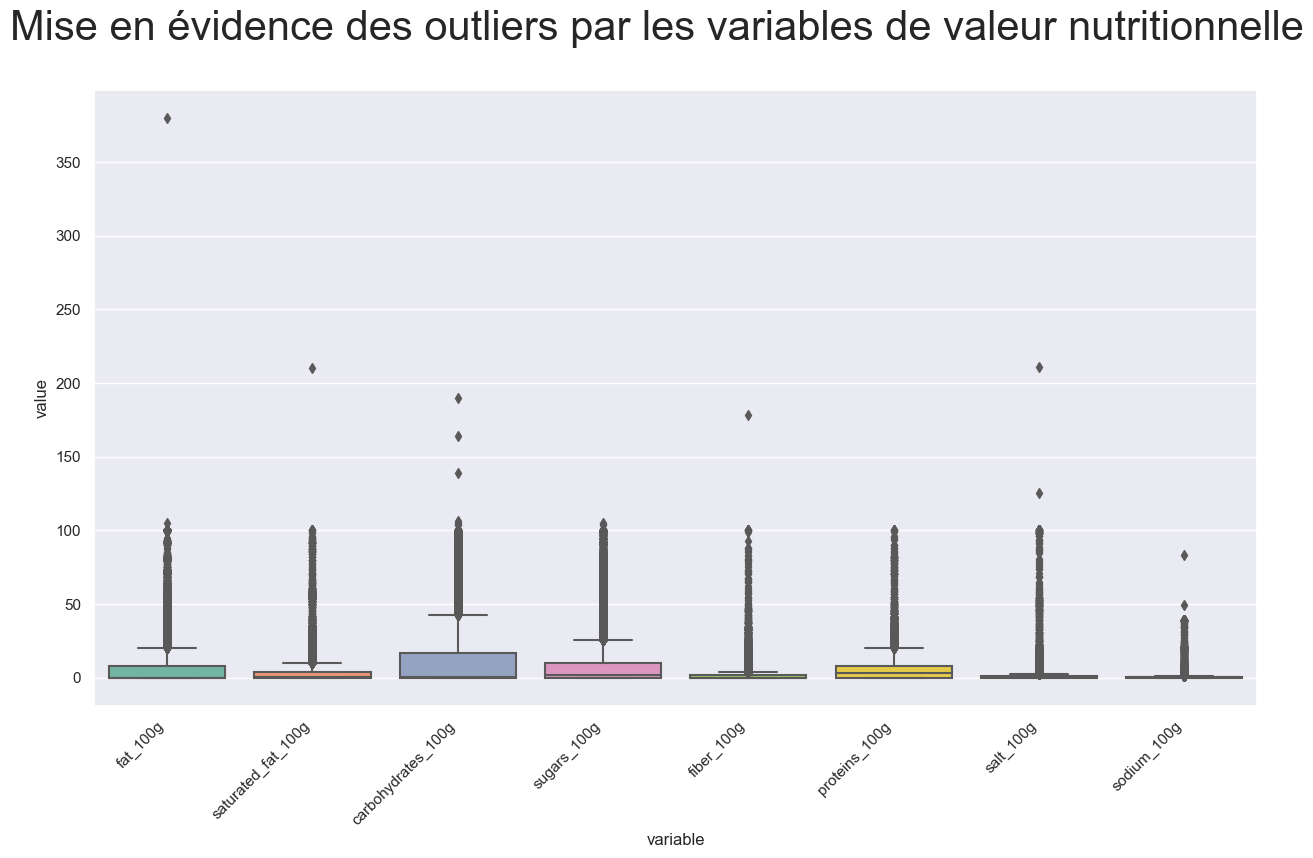

In [55]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Mise en évidence des outliers par les variables de valeur nutritionnelle',
             fontsize=30)

chart = sns.boxplot(
    data=pd.melt(data_chiffres[['fat_100g', 'saturated_fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g']]),
    x='variable',
    y='value',
    palette='Set2'
)

chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45,
                      horizontalalignment='right',
                      fontweight='light');

Nous choisissons d'utiliser les boites à moustaches en plus du tableau statistique afin de visualiser les données extremes. Nous constatons que des valeurs supérieurs à 100g sont présentes. Nous considérons que des quantités supérieurs à 100g pour un poids totale de 100g sont des données erronées. Nous les supprimerons.

In [56]:
data_fr.head()

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000003087,20160917,20160917,Farine de blé noir,0,1kg,0,Ferme t'y R'nao,0,0,France,0,0,0,0.0,0,0.0,0.0,0,0,0,"A compléter,Informations nutritionnelles à com...",0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000,0.0
0000000024600,20150617,20150617,Filet de bœuf,0,2.46 kg,plastique,0,Filet-de-boeuf,0,France,0,0,0,0.0,0,0.0,0.0,0,unknown,unknown,"A compléter,Informations nutritionnelles à com...",Filet-de-boeuf,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000,0.0
0000000027205,20160317,20160317,0,0,0,0,0,0,0,France,0,0,0,0.0,0,0.0,0.0,0,0,0,"A compléter,Informations nutritionnelles à com...",0,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000,0.0
0000000036252,20150125,20170309,Lion Peanut x2,0,0,0,Sunridge,0,0,"France,États-Unis","Milk chocolate coating (evaporated cane juice,...",0,40 g (0.25 cup),1.0,E322 - Lécithines,0.0,0.0,e,unknown,unknown,"A compléter,Informations nutritionnelles compl...",0,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...,1883.0,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038,22.0
0000000039259,20150125,20160910,Twix x2,0,0,0,0,0,0,France,0,0,0,0.0,0,0.0,0.0,0,unknown,unknown,"A compléter,Informations nutritionnelles à com...",0,http://fr.openfoodfacts.org/images/products/00...,http://fr.openfoodfacts.org/images/products/00...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000,0.0


### Traitement des outliers sur la valeur fat_100
Les valeurs ayant des oultiers ont été identifiées et le traitement consistera en la suppression des valeurs supérieurs à 100 Modification sur le df data_fr.

In [57]:
outliers_data(data_fr, 'fat_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Traitement des outliers sur la valeur saturated_fat_100

In [58]:
outliers_data(data_fr, 'saturated_fat_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Traitement des outliers sur la variables carbohydrates_100g

In [59]:
outliers_data(data_fr, 'carbohydrates_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Traitement des outliers sur la variable fiber_100g

In [60]:
outliers_data(data_fr, 'fiber_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Traitement des outliers sur la variable salt_100g

In [61]:
outliers_data(data_fr, 'salt_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Traitement des outliers sur la variable sugars_100g

In [62]:
outliers_neg(data_fr, 'sugars_100g')

,created_t,last_modified_t,product_name,generic_name,quantity,packaging,brands,categories_fr,labels_fr,countries_fr,ingredients_text,traces_fr,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,image_url,image_small_url,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Visualisation du résultat du traitement
Nous contrôlons le résultat de notre traitement en affichant les boites à moustaches et les statistiques des features traitées.

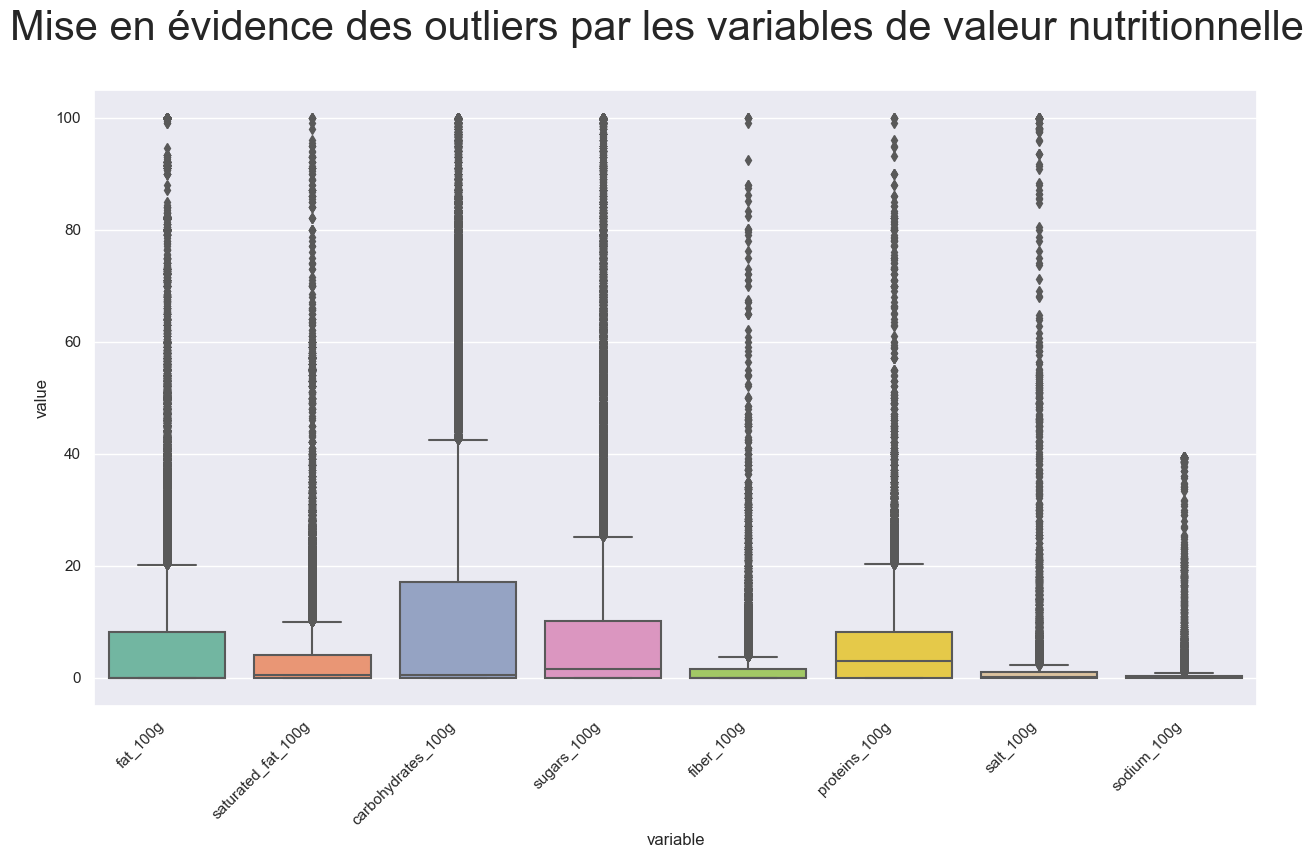

In [63]:

fig = plt.figure(figsize=(15,8))
fig.suptitle('Mise en évidence des outliers par les variables de valeur nutritionnelle',
             fontsize=30)

chart = sns.boxplot(
    data=pd.melt(data_fr[['fat_100g', 'saturated_fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g']]),
    x='variable',
    y='value',
    palette='Set2'
)

chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45,
                      horizontalalignment='right',
                      fontweight='light');

In [64]:
data_fr.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
count,86971.00000,86971.00000,86971.00000,8.69710e+04,86971.00000,86971.00000,86971.00000,86971.00000,86971.00000,86971.00000,86971.00000,86971.00000,86971.00000
mean,1.11251,0.04201,0.08919,8.56723e+02,7.12321,3.82819,14.80391,9.49649,1.32940,5.65777,0.82102,0.32324,6.02507
std,2.18435,0.20341,0.35759,1.10735e+04,13.88444,7.54222,24.30889,17.13042,3.53551,7.56816,3.59294,1.41454,8.53164
min,0.00000,0.00000,0.00000,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-15.00000
25%,0.00000,0.00000,0.00000,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,5.44000e+02,0.00000,0.50000,0.50000,1.50000,0.00000,3.00000,0.10000,0.03937,2.00000
75%,1.00000,0.00000,0.00000,1.48100e+03,8.10000,4.00000,17.00000,10.10000,1.50000,8.10000,0.94000,0.37008,13.00000
max,31.00000,2.00000,5.00000,3.25137e+06,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,39.37008,40.00000


## Feature Engineering

### Tri du nutrition grade

Le nutrition grade est composé des valeurs A, B, C, D, et E. Nous supprimons le reste

In [65]:
compte = data_fr.groupby('nutrition_grade_fr').nunique().reset_index()

In [66]:
# On affiche toutes les valeurs présentes
compte['nutrition_grade_fr'].value_counts()

0    1
a    1
b    1
c    1
d    1
e    1
Name: nutrition_grade_fr, dtype: int64

In [67]:
score = data_fr[data_fr.nutrition_grade_fr == 0].index
data_fr.drop(score, axis = 0, inplace = True)

In [68]:
# Vérification
data_fr['nutrition_grade_fr'].value_counts()

d    16723
c    13009
e    11562
a    10091
b     9069
Name: nutrition_grade_fr, dtype: int64

### Traitement de la valeur energy_100
La valeur est exprimée en kjoule et non en kcal, pour la convertir, nous diviserons la variable par 4,184

In [69]:
data_fr.columns

Index(['created_t', 'last_modified_t', 'product_name', 'generic_name',
       'quantity', 'packaging', 'brands', 'categories_fr', 'labels_fr',
       'countries_fr', 'ingredients_text', 'traces_fr', 'serving_size',
       'additives_n', 'additives_fr', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states_fr', 'main_category_fr',
       'image_url', 'image_small_url', 'energy_100g', 'fat_100g',
       'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_score_fr_100g'],
      dtype='object')

In [70]:
# On divise les valeurs en Kjoule par 4,184 afin de les avoir en Kcal
data_fr.energy_100g = data_fr.energy_100g / 4.184

In [71]:
#On selectionne les valeurs au dessus de 4000 kcal, qui sont très certainement des outliers
kcal = data_fr[data_fr['energy_100g'] > 4000].index

In [72]:
# On les supprime
data_fr.drop(kcal, axis = 0, inplace = True)

In [73]:
data_fr['energy_100g']

code
0000000036252    450.04780
0000010187319    418.97706
0000010207260    575.04780
0000040608754     42.30402
0000069161025    257.88719
                   ...    
9782211109758    259.08222
9782401029101      0.95602
9847548283004    392.68642
9900000000233    575.04780
99111250           5.01912
Name: energy_100g, Length: 60451, dtype: float64

Notre fichier fait 60451 lignes

### Traitement des features pnns_group_2 et main_category_fr

In [74]:
data_fr['pnns_groups_2']

code
0000000036252                  unknown
0000010187319                        0
0000010207260                        0
0000040608754      Sweetened beverages
0000069161025                        0
                         ...          
9782211109758                        0
9782401029101                        0
9847548283004                    Bread
9900000000233                        0
99111250         Non-sugared beverages
Name: pnns_groups_2, Length: 60451, dtype: object

In [75]:
# Nous remplaçons les valeurs 'unknown' par 'Autres'
data_fr['pnns_groups_2'] = data_fr['pnns_groups_2'].replace('unknown', 'Autres')
print('pnns_groups_2 :\n',data_fr['pnns_groups_2'].unique())


pnns_groups_2 :
 ['Autres' 0 'Sweetened beverages' 'Biscuits and cakes' 'One-dish meals'
 'Soups' 'Non-sugared beverages' 'Cheese' 'Sweets' 'Sandwich'
 'Dressings and sauces' 'Appetizers' 'Nuts' 'Dried fruits'
 'Breakfast cereals' 'Pizza pies and quiche' 'Fruits' 'Fruit juices'
 'Cereals' 'Vegetables' 'Bread' 'Chocolate products' 'Processed meat'
 'Legumes' 'vegetables' 'Ice cream' 'Fish and seafood' 'pastries'
 'Milk and yogurt' 'Dairy desserts' 'Alcoholic beverages' 'Meat' 'Fats'
 'Artificially sweetened beverages' 'Fruit nectars' 'Potatoes'
 'Salty and fatty products' 'Tripe dishes' 'Eggs' 'fruits' 'cereals']


In [76]:
# Nous remplaçons les valeurs '0' par 'Autres'
data_fr['pnns_groups_2'] = data_fr['pnns_groups_2'].replace(0, 'Autres')
print('pnns_groups_2 :\n',data_fr['pnns_groups_2'].unique())


pnns_groups_2 :
 ['Autres' 'Sweetened beverages' 'Biscuits and cakes' 'One-dish meals'
 'Soups' 'Non-sugared beverages' 'Cheese' 'Sweets' 'Sandwich'
 'Dressings and sauces' 'Appetizers' 'Nuts' 'Dried fruits'
 'Breakfast cereals' 'Pizza pies and quiche' 'Fruits' 'Fruit juices'
 'Cereals' 'Vegetables' 'Bread' 'Chocolate products' 'Processed meat'
 'Legumes' 'vegetables' 'Ice cream' 'Fish and seafood' 'pastries'
 'Milk and yogurt' 'Dairy desserts' 'Alcoholic beverages' 'Meat' 'Fats'
 'Artificially sweetened beverages' 'Fruit nectars' 'Potatoes'
 'Salty and fatty products' 'Tripe dishes' 'Eggs' 'fruits' 'cereals']


In [77]:
# Vérification
data_fr['pnns_groups_2'].value_counts()

Autres                              21176
One-dish meals                       4014
Biscuits and cakes                   3202
Cereals                              2497
Sweets                               2287
Cheese                               2195
Processed meat                       2095
Dressings and sauces                 1876
Chocolate products                   1762
Milk and yogurt                      1729
Fish and seafood                     1530
Appetizers                           1407
Sweetened beverages                  1300
Fruit juices                         1286
Non-sugared beverages                1265
Vegetables                           1097
Bread                                1091
Breakfast cereals                    1013
Fruits                                924
Fats                                  856
Meat                                  788
Dairy desserts                        659
Sandwich                              589
Ice cream                         

### Traitement de la variable product name


In [78]:
#Nettoyage des Nan
data_fr['product_name'].isnull().value_counts()

False    60451
Name: product_name, dtype: int64

Il n'y a pas de Nan sur cette valeur

In [79]:
#Nettoyage des produits à 0
products = data_fr[data_fr['product_name']  == '0' ].index
data_fr.drop(products, axis = 0, inplace = True)

In [80]:
#Nettoyage des Nan
data_fr['product_name'].value_counts()

0                                                        335
Mayonnaise                                                39
Orange                                                    36
Huile d'olive vierge extra                                31
Jus d'orange                                              30
                                                        ... 
Tarte à la savoyarde                                       1
Petites Tranches Saumon                                    1
Saumon Atlantique fumé élévé en Norvège U, 2 tranches      1
Velouté de Potiron et Châtaignes                           1
Thé vert Earl grey                                         1
Name: product_name, Length: 51109, dtype: int64

Nous avons supprimé 9342 valeurs

In [81]:
#Creation d'un tableau donnant les moyennes et les médianes des indicateurs retenus pour le choix final
files_description = pd.DataFrame(columns = ["Minimum", "Maximum", "Médianes", "Moyennes", "Variance", "Ecart-Type"],
                                 index = ["energy_100g",
                                          "fat_100g",
                                          "saturated_fat_100g",
                                          "carbohydrates_100g",
                                          "sugars_100g",
                                          "fiber_100g",
                                          "proteins_100g",
                                          "salt_100g",
                                          "sodium_100g",
                                          "nutrition_score_fr_100g"])

#Remplissage des minimum pour chaque indicateur
files_description["Minimum"] = [
    round(data_fr['energy_100g'].min(),2),
    round(data_fr['fat_100g'].min(),2),
    round(data_fr['saturated_fat_100g'].min(),2),
    round(data_fr['carbohydrates_100g'].min(),2),
    round(data_fr['sugars_100g'].min(),2),
    round(data_fr['fiber_100g'].min(),2),
    round(data_fr['proteins_100g'].min(),2),
    round(data_fr['salt_100g'].min(),2),
    round(data_fr['sodium_100g'].min(),2),
    round(data_fr['nutrition_score_fr_100g'].min(),2)
]

#Remplissage des maximum pour chaque indicateur
files_description["Maximum"] = [
    round(data_fr['energy_100g'].max(),2),
    round(data_fr['fat_100g'].max(),2),
    round(data_fr['saturated_fat_100g'].max(),2),
    round(data_fr['carbohydrates_100g'].max(),2),
    round(data_fr['sugars_100g'].max(),2),
    round(data_fr['fiber_100g'].max(),2),
    round(data_fr['proteins_100g'].max(),2),
    round(data_fr['salt_100g'].max(),2),
    round(data_fr['sodium_100g'].max(),2),
    round(data_fr['nutrition_score_fr_100g'].max(),2)
]

#Remplissage des médianes pour chaque indicateur
files_description["Médianes"] = [
    round(data_fr['energy_100g'].median(),2),
    round(data_fr['fat_100g'].median(),2),
    round(data_fr['saturated_fat_100g'].median(),2),
    round(data_fr['carbohydrates_100g'].median(),2),
    round(data_fr['sugars_100g'].median(),2),
    round(data_fr['fiber_100g'].median(),2),
    round(data_fr['proteins_100g'].median(),2),
    round(data_fr['salt_100g'].median(),2),
    round(data_fr['sodium_100g'].median(),2),
    round(data_fr['nutrition_score_fr_100g'].median(),2)
]

#Remplissage des moyennes pour chaque fichier
files_description["Moyennes"] = [
    round(data_fr['energy_100g'].mean(),2),
    round(data_fr['fat_100g'].mean(),2),
    round(data_fr['saturated_fat_100g'].mean(),2),
    round(data_fr['carbohydrates_100g'].mean(),2),
    round(data_fr['sugars_100g'].mean(),2),
    round(data_fr['fiber_100g'].mean(),2),
    round(data_fr['proteins_100g'].mean(),2),
    round(data_fr['salt_100g'].mean(),2),
    round(data_fr['sodium_100g'].mean(),2),
    round(data_fr['nutrition_score_fr_100g'].mean(),2)
]

#Remplissage de la variance pour chaque fichier
files_description["Variance"] = [
    round(data_fr['energy_100g'].var(),2),
    round(data_fr['fat_100g'].var(),2),
    round(data_fr['saturated_fat_100g'].var(),2),
    round(data_fr['carbohydrates_100g'].var(),2),
    round(data_fr['sugars_100g'].var(),2),
    round(data_fr['fiber_100g'].var(),2),
    round(data_fr['proteins_100g'].var(),2),
    round(data_fr['salt_100g'].var(),2),
    round(data_fr['sodium_100g'].var(),2),
    round(data_fr['nutrition_score_fr_100g'].var(),2)
]

#Remplissage de l'écart-type pour chaque fichier
files_description["Ecart-Type"] = [
    round(data_fr['energy_100g'].std(),2),
    round(data_fr['fat_100g'].std(),2),
    round(data_fr['saturated_fat_100g'].std(),2),
    round(data_fr['carbohydrates_100g'].std(),2),
    round(data_fr['sugars_100g'].std(),2),
    round(data_fr['fiber_100g'].std(),2),
    round(data_fr['proteins_100g'].std(),2),
    round(data_fr['salt_100g'].std(),2),
    round(data_fr['sodium_100g'].std(),2),
    round(data_fr['nutrition_score_fr_100g'].std(),2)
]

files_description

,Minimum,Maximum,Médianes,Moyennes,Variance,Ecart-Type
energy_100g,0.0,3700.05,248.57,268.25,35352.33,188.02
fat_100g,0.0,100.00,2.00,9.51,230.36,15.18
saturated_fat_100g,0.0,100.00,2.00,5.43,72.23,8.50
carbohydrates_100g,0.0,100.00,5.80,19.95,688.67,26.24
sugars_100g,0.0,100.00,4.00,13.37,359.68,18.97
fiber_100g,0.0,100.00,0.10,1.86,16.42,4.05
proteins_100g,0.0,100.00,6.00,7.75,61.53,7.84
salt_100g,0.0,100.00,0.55,1.08,13.67,3.70
sodium_100g,0.0,39.37,0.22,0.42,2.12,1.46
nutrition_score_fr_100g,-15.0,40.00,9.00,8.67,81.81,9.04


# Sauvegarde du dataset nettoyé


In [83]:
data_fr.to_csv('/Users/xavierparisot/Formation OpenClassRoom/Projets/Projet 3/fr_data_clean.csv', index=False)